In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Adding Tasks](#Adding-tasks)
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
* [Algorithme distribué k-tâches 2-classes](#Algorithme-distribué-k-tâches-m-classes)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [3]:
def mean_random_matrix(m, k, p, l, h, random_seed=42):
    """
    Retourne une matrice M de taille pxm*k contenant
    les moyennes de chaque composante de chaque vecteur aléatoire
    pour l'instant les moyennes sont tirées aléatoirement 
    suivant la loi uniforme sur l, h (pas convaincu par ce choix)
    m est le nombre de classes
    k est le nombre de taches
    p est le nombre de features
    """
    np.random.seed(random_seed)
    M = []
    tmp = []
    for task in range(k):
        tmp = []
        for classe in range(m):
            # on crée un vecteur de moyennes égales pour chaque classes
            # de sorte à créer des classes gravitant autour d'une meme moyenne
            tmp.append(np.ones((p,1))*np.random.uniform(low = 0.0, high = h))
        M.append(tmp)
    return M

In [4]:
def mean_matrix(p, beta=None, k=2, m=2, random_seed=42, random=False):
    """
    Crée des vecteurs de moyennes en respectant les conditions de non trivialité 
    retourne un tableau contenant k tableaux de m moyennes.
    beta est le paramètre de task relatedness. Si beta n'est pas précisé, il est tiré au hasard uniformément sur [0,1] pour chaque t.
    k=2, m=2 par défaut
    """
    np.random.seed(random_seed)
    mu = np.zeros((p,1))
    mu[0]= 1
    mu_ortho = np.zeros((p,1))
    mu_ortho[-1] = 1
    
    M = []
    classes = []
    for l in range(m):
        classes.append((-1)**l*mu)
    M.append(classes)
    
    for t in range(1, k):
        if random:
            beta = np.random.uniform(0, 1)
        print(beta)
        mu_t = beta*mu+np.sqrt(1-beta**2)*mu_ortho
        classes = []
        for l in range(m):
            classes.append((-1)**l*mu_t)
        M.append(classes)
    return M

In [5]:
def gaussian_synthetic_data(n, p, m, t, n_t, M, random_seed=42):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    
    np.random.seed(random_seed)
    X = []
    tmp = []
    y_test = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
#             print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                # std = 1?
                # comment utiliser des vecteurs de moyennes pour générer les données ?
                mean = np.reshape(M[task][k], p)
                X_k[j] = np.random.multivariate_normal(mean, np.identity(p))
                y_test.append(k)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X, y_test

In [6]:
def normalisation(X, p):
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] *= 1/np.sqrt(p)
    
    return X

## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [7]:
def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((nb_tasks*nb_classes, nb_tasks*nb_classes)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
                        #print(f"i = {i}, j = {j}")
                        print(i*nb_classes+j, i*nb_classes+j)
                        print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
                        M[i*nb_classes+j][i*nb_classes+j] = np.ones((moitie, 1)).T@X[i][j].T[:moitie]@X[i][j].T[moitie:].T@np.ones((moitie))
                        M[i*nb_classes+j][i*nb_classes+j] /= moitie**2
                    else:
                        #print(i*nb_tasks+j, k*nb_tasks+l)
                        #print(i, j, k, l)
                        M[i*nb_classes+j][k*nb_classes+l] = np.ones((n_t[i][j], 1)).T@X[i][j].T@X[k][l]@np.ones((n_t[k][l]))
                        M[i*nb_classes+j][k*nb_classes+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
                
    return M

In [8]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (p,))
            true_M[t*nb_classes+l] = mean

    return np.transpose(true_M)

In [9]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [10]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    """
    Estime le vecteur c en divisant n_t[nb_tasks][nb_classes]/n
    """
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [11]:
def compute_M_cal(n,p,Dc,MM, k=2, display=False):
    """
    renvoie la matrice M cursive estimée.
    """
    c0 = k*p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2)@MM@np.power(Dc, 1/2)
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

## 3ème étape
Let's compute optimal labels

In [12]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated, c0):
    """
    Evalue le label y pour une tache t pour 2 classes
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    power_dc = power_diagonal_matrix(Dc, -1/2)
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    e3_e4[-2] = 1
    e3_e4[-1] = -1
    print("e3 - e4 : ")
    matprint(e3_e4)
    tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    return tilde_y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [13]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [14]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [15]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_classes+j] = 1
            beg += n_t[t][j]
    return J

In [16]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    return V.T[idx_larg].real

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [17]:
def create_mt(t, m, y, Dc, correlation_matrix):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l))
        m_t.append(m_tj)

    return m_t

In [18]:
def compute_score(V, x, m_t):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
    average_mean = 1/2*(m_t[0] + m_t[1])
    return (1 if x_projection > 0 else -1) 

In [19]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [20]:
def error_rate(nb_tasks, nb_classes, Dc, M_cur, c0):
    e3 = np.zeros((nb_tasks*nb_classes, 1))
    e3[-2] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(nb_tasks*nb_classes))
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [21]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [22]:
def compute_error_rate(X_test, V, m_t, nb_tasks, nb_classes, n_t, Dc, c0):
    """
    Compute and plot classification error rate on test set
    """
#     print("mt1= \n", m_t[1])
    emp_rate = []
    error = 0
    ni = 0
    for t in range(nb_tasks):
        error = 0
        ni = sum(n_t[t])
        for l in range(nb_classes):
            for i in range(n_t[t][l]):
                # on prend la transposée pour pouvoir travailler avec les colonnes
                score = compute_score(V, X_test[t][l].T[i], m_t[-1])
                if (score == 1 and l == 1):
                    error +=1
                elif (score == -1 and l == 0):
                    error +=1
        
        erreur_emp = error/ni
        
        if erreur_emp > 0.5:
            erreur_emp=1-erreur_emp
        emp_rate.append(erreur_emp)
    return np.mean(emp_rate)

In [23]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$")
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$")
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

# 2-class Gaussian mixture transfer (c.f. Figure 2)

In [24]:
from time import time
plt.style.use('seaborn-dark-palette')

0.0
0 0
500
1 1
500
2 2
25
3 3
25
MM : 
 [[ 0.95192386 -0.96953935  0.21400559 -0.04360498]
 [-0.96953935  1.0012283  -0.21980622  0.07171104]
 [ 0.21400559 -0.21980622  0.82424997 -1.02778683]
 [-0.04360498  0.07171104 -1.02778683  0.84253941]]
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


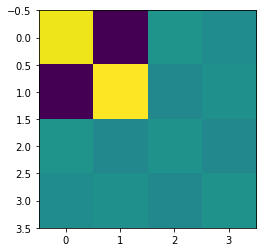

   4.75962    -4.8477   0.239266  -0.0487519  
   -4.8477    5.00614  -0.245751   0.0801754  
  0.239266  -0.245751   0.206062   -0.256947  
-0.0487519  0.0801754  -0.256947    0.210635  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1. -1.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0.  0.  1. -1.]
 [ 0.  0. -1.  1.]]
 5  -5      0      0  
-5   5      0      0  
 0   0   0.25  -0.25  
 0   0  -0.25   0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.00885528  
 -0.285474  
   19.6689  
  -20.3765  
y true = 
  0  
  0  
 21  
-21  
arg q-func : 
[[0.5]]
[0.26349999999999996] [0.23975006109347674]
0.1111111111111111
0 0
500
1 1
500
2 2
25
3 3
25
MM : 
 [[ 0.95192386 -0.96953935  0.32224881 -0.1518482 ]
 [-0.96953935  1.0012283  -0.33061393  0.18251876]
 [ 0.32224881 -0.33061393  0.87925669 -1.06243508]
 [-0.1518482   0.18251876 -1.06243508  0.85682921]]
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


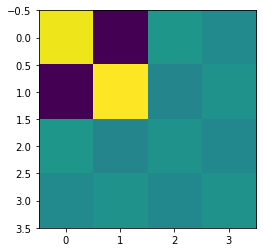

  4.75962    -4.8477   0.360285  -0.169771  
  -4.8477    5.00614  -0.369638   0.204062  
 0.360285  -0.369638   0.219814  -0.265609  
-0.169771   0.204062  -0.265609   0.214207  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.11111111 -0.11111111]
 [-1.          1.         -0.11111111  0.11111111]
 [ 0.11111111 -0.11111111  1.         -1.        ]
 [-0.11111111  0.11111111 -1.          1.        ]]
        5         -5   0.124226  -0.124226  
       -5          5  -0.124226   0.124226  
 0.124226  -0.124226       0.25      -0.25  
-0.124226   0.124226      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.127293  
-0.403797  
  19.6344  
 -20.2631  
y true = 
 0.111768  
-0.111768  
  20.8758  
 -20.8758  
arg q-func : 
[[0.50295683]]
[0.26349999999999996, 0.264] [0.23975006109347674, 0.23910189492427802]
0.2222222222222222
0 0
500
1 1
500
2 2
25
3 3
25
MM : 
 [[ 0.95192386 -0.96953935  0.43038924 -0.25998863]
 [-0.96953935  1

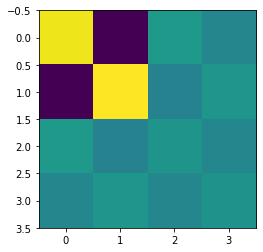

  4.75962    -4.8477    0.48119  -0.290676  
  -4.8477    5.00614  -0.493995    0.32842  
  0.48119  -0.493995   0.234537  -0.274623  
-0.290676    0.32842  -0.274623   0.217513  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.22222222 -0.22222222]
 [-1.          1.         -0.22222222  0.22222222]
 [ 0.22222222 -0.22222222  1.         -1.        ]
 [-0.22222222  0.22222222 -1.          1.        ]]
        5         -5   0.248452  -0.248452  
       -5          5  -0.248452   0.248452  
 0.248452  -0.248452       0.25      -0.25  
-0.248452   0.248452      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.243784  
-0.534739  
   19.366  
  -19.859  
y true = 
 0.227574  
-0.227574  
  20.4943  
 -20.4943  
arg q-func : 
[[0.51204094]]
[0.26349999999999996, 0.264, 0.252] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354]
0.3333333333333333
0 0
500
1 1
500
2 2
25
3 3
25
MM : 
 [[ 0.95192386 -0.96953935  0.53842072 -

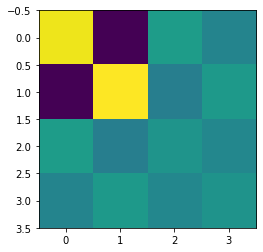

  4.75962    -4.8477   0.601973  -0.411459  
  -4.8477    5.00614  -0.618852   0.453277  
 0.601973  -0.618852    0.25029   -0.28401  
-0.411459   0.453277   -0.28401   0.220535  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.33333333 -0.33333333]
 [-1.          1.         -0.33333333  0.33333333]
 [ 0.33333333 -0.33333333  1.         -1.        ]
 [-0.33333333  0.33333333 -1.          1.        ]]
        5         -5   0.372678  -0.372678  
       -5          5  -0.372678   0.372678  
 0.372678  -0.372678       0.25      -0.25  
-0.372678   0.372678      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
  0.36215  
-0.684039  
  18.8441  
 -19.1329  
y true = 
 0.351955  
-0.351955  
  19.8268  
 -19.8268  
arg q-func : 
[[0.52793296]]
[0.26349999999999996, 0.264, 0.252, 0.245] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528]
0.4444444444444444
0 0
500
1 1
500
2 2
25
3 3
25
MM : 
 [[ 0.951923

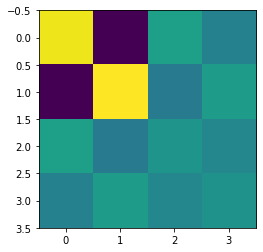

  4.75962    -4.8477   0.722621  -0.532107  
  -4.8477    5.00614  -0.744262   0.578687  
 0.722621  -0.744262   0.267183  -0.293811  
-0.532107   0.578687  -0.293811   0.223243  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.44444444 -0.44444444]
 [-1.          1.         -0.44444444  0.44444444]
 [ 0.44444444 -0.44444444  1.         -1.        ]
 [-0.44444444  0.44444444 -1.          1.        ]]
        5         -5   0.496904  -0.496904  
       -5          5  -0.496904   0.496904  
 0.496904  -0.496904       0.25      -0.25  
-0.496904   0.496904      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.486382  
-0.859689  
  18.0303  
 -18.0251  
y true = 
 0.490591  
-0.490591  
  18.8196  
 -18.8196  
arg q-func : 
[[0.55191434]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643]
0.5555555555555556
0 0
500

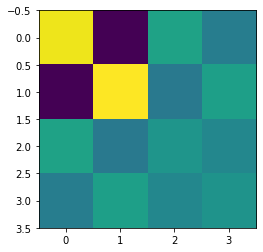

  4.75962    -4.8477   0.843111  -0.652597  
  -4.8477    5.00614  -0.870319   0.704743  
 0.843111  -0.870319   0.285409  -0.304095  
-0.652597   0.704743  -0.304095   0.225585  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.55555556 -0.55555556]
 [-1.          1.         -0.55555556  0.55555556]
 [ 0.55555556 -0.55555556  1.         -1.        ]
 [-0.55555556  0.55555556 -1.          1.        ]]
       5        -5   0.62113  -0.62113  
      -5         5  -0.62113   0.62113  
 0.62113  -0.62113      0.25     -0.25  
-0.62113   0.62113     -0.25      0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.620993  
-1.07353  
 16.8601  
-16.4332  
y true = 
 0.651275  
-0.651275  
  17.3818  
 -17.3818  
arg q-func : 
[[0.58614748]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999, 0.2275] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154]
0.666666666666666

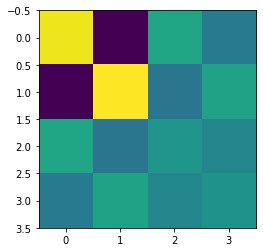

  4.75962    -4.8477   0.963402  -0.772889  
  -4.8477    5.00614  -0.997188   0.831613  
 0.963402  -0.997188   0.305314  -0.314988  
-0.772889   0.831613  -0.314988   0.227466  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.66666667 -0.66666667]
 [-1.          1.         -0.66666667  0.66666667]
 [ 0.66666667 -0.66666667  1.         -1.        ]
 [-0.66666667  0.66666667 -1.          1.        ]]
        5         -5   0.745356  -0.745356  
       -5          5  -0.745356   0.745356  
 0.745356  -0.745356       0.25      -0.25  
-0.745356   0.745356      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.771271  
-1.34432  
 15.2316  
-14.1859  
y true = 
 0.845638  
-0.845638  
  15.3624  
 -15.3624  
arg q-func : 
[[0.63422819]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999, 0.2275, 0.217] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.2219563706212

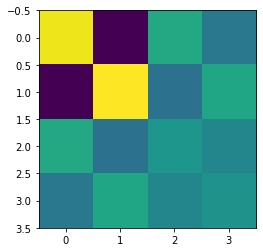

  4.75962   -4.8477    1.08341  -0.892901  
  -4.8477   5.00614    -1.1252   0.959628  
  1.08341   -1.1252   0.327581  -0.326737  
-0.892901  0.959628  -0.326737   0.228697  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.77777778 -0.77777778]
 [-1.          1.         -0.77777778  0.77777778]
 [ 0.77777778 -0.77777778  1.         -1.        ]
 [-0.77777778  0.77777778 -1.          1.        ]]
        5         -5   0.869582  -0.869582  
       -5          5  -0.869582   0.869582  
 0.869582  -0.869582       0.25      -0.25  
-0.869582   0.869582      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.942803  
-1.70434  
 12.9862  
-10.9868  
y true = 
 1.09249  
-1.09249  
 12.5029  
-12.5029  
arg q-func : 
[[0.70231214]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999, 0.2275, 0.217, 0.1965] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.2219563706212

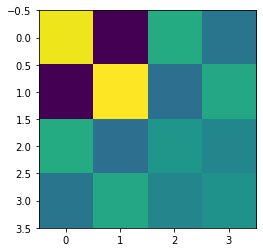

 4.75962   -4.8477    1.20294   -1.01243  
 -4.8477   5.00614   -1.25522    1.08964  
 1.20294  -1.25522   0.353973  -0.339981  
-1.01243   1.08964  -0.339981   0.228793  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.88888889 -0.88888889]
 [-1.          1.         -0.88888889  0.88888889]
 [ 0.88888889 -0.88888889  1.         -1.        ]
 [-0.88888889  0.88888889 -1.          1.        ]]
        5         -5   0.993808  -0.993808  
       -5          5  -0.993808   0.993808  
 0.993808  -0.993808       0.25      -0.25  
-0.993808   0.993808      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 1.13561  
-2.21701  
  9.9028  
-6.27957  
y true = 
 1.42507  
-1.42507  
  8.3327  
 -8.3327  
arg q-func : 
[[0.80160226]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999, 0.2275, 0.217, 0.1965, 0.1755] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.221956370

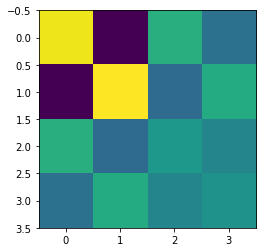

 4.75962   -4.8477    1.31984   -1.12933  
 -4.8477   5.00614   -1.39597     1.2304  
 1.31984  -1.39597   0.402512  -0.361254  
-1.12933    1.2304  -0.361254     0.2228  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]
 [ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]]
       5        -5   1.11803  -1.11803  
      -5         5  -1.11803   1.11803  
 1.11803  -1.11803      0.25     -0.25  
-1.11803   1.11803     -0.25      0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 1.17387  
-3.14005  
 6.76583  
 1.55053  
y true = 
 1.90909  
-1.90909  
 1.90909  
-1.90909  
arg q-func : 
[[0.95454545]]
[0.26349999999999996, 0.264, 0.252, 0.245, 0.23399999999999999, 0.2275, 0.217, 0.1965, 0.1755, 0.1425] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]
Erreur relative moyenne pour n=2100 et p=10

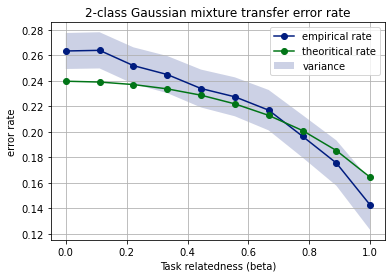

In [32]:
# %%prun -s cumulative
# profiling
p = 100
m = 2
t = 2
beta = np.linspace(0,1,10)
n_t = [[1000, 1000], [50, 50]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
random_state = 100

for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
    
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(t, m, X, p, n_t)
    print("MM : \n", MM)
    temps_MM.append(time() - t0)
    # On time le calcul de MTM

    t0 = time()
    c = estimate_c(n_t, n, t, m)
    print("c : ")
    print(c)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=True)
    matprint(correlation_matrix)
    y = label_evaluation(t,m,Dc,MM, c0)
    temps_estim.append(time() - t0)
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    print("MM True = ")
    print(MM_true)
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    matprint(correlation_matrix_true)
    print("c0 : ", c0)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    print("y = ")
    matprint(y)
    print("y true = ")
    matprint(y_true)
    X = normalisation(X, p)
    X_test = normalisation(X_test, p)
    X_train_aggregated = aggregate_array(X, p, n, t, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    J = create_J(m, t, n, n_t)
    
    t0 = time()
    V = compute_V(y, X_train_aggregated, J, n)
    temps_inference.append(time() - t0)
    # On time le temps d'inférence
    
    V_true = compute_V(y_true, X_train_aggregated, J, n)
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
    # pour l'instant pas vraiment utilisé
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true)
    
    erreur_empirique = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0)
    erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    print(emp_rate, th_rate)
    
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [70]:
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
print(n)
print("c0 : ", c0)
print(c)
print("y true = ")
matprint(y_true)

1600
c0 :  0.0625
[0.25  0.25  0.125 0.125 0.125 0.125]
y true = 
 1.88235  
-1.88235  
 1.88235  
-1.88235  
 1.88235  
-1.88235  


In [71]:
print(y_test.count(1))

1000


Results when doubling n and p proportionately: 
[0.244, 0.2395, 0.23624999999999996, 0.23624999999999996, 0.22999999999999998, 0.2195, 0.21050000000000002, 0.195, 0.17700000000000005, 0.15674999999999994] 
[0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]

Erreur relative moyenne pour n=2100 et p=100, moyennée sur 10 simulations et 1000 données de test : 0.115
En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur 2.126778599820526
Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : 0.00401 s, 0.00064 s, 0.00889 s.
Le temps total moyen est ainsi de 0.00465 s


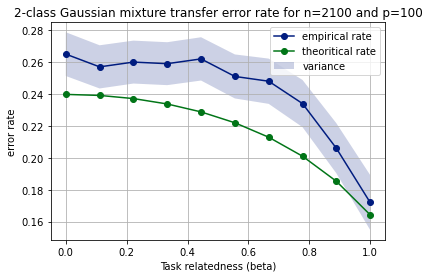

In [50]:
erreur_relative_prec = 0.054
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations et {nt} données de test : {round(erreur_relative_moy, 3)}")

print(f"En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur {(1/(erreur_relative_prec/erreur_relative_moy))}")


print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {round(np.mean(temps_MM), 5)} s, {round(np.mean(temps_estim), 5)} s, {round(np.mean(temps_inference), 5)} s.\nLe temps total moyen est ainsi de {round(np.mean(temps_estim) + np.mean(temps_MM) , 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [59]:
debug_histogram(V, X_test_aggregated, n_t_test)

ValueError: shapes (200,) and (100,1000) not aligned: 200 (dim 0) != 100 (dim 0)

# Adding tasks

2
[[1000, 1000], [200, 200]]
2400
0.3745401188473625
0 0
500
1 1
500
2 2
100
3 3
100
MM : 
 [[ 1.04247939 -1.01024803  0.56981732 -0.42969837]
 [-1.01024803  1.01042755 -0.53098643  0.41750456]
 [ 0.56981732 -0.53098643  1.24166146 -1.12661383]
 [-0.42969837  0.41750456 -1.12661383  1.02642988]]
c : 
[0.41666667 0.41666667 0.08333333 0.08333333]


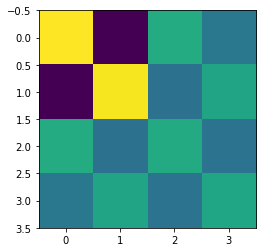

   5.2124  -5.05124   1.27415  -0.960835  
 -5.05124   5.05214  -1.18732   0.933569  
  1.27415  -1.18732   1.24166   -1.12661  
-0.960835  0.933569  -1.12661    1.02643  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.37454012 -0.37454012]
 [-1.          1.         -0.37454012  0.37454012]
 [ 0.37454012 -0.37454012  1.         -1.        ]
 [-0.37454012  0.37454012 -1.          1.        ]]
        5         -5   0.837497  -0.837497  
       -5          5  -0.837497   0.837497  
 0.837497  -0.837497          1         -1  
-0.837497   0.837497         -1          1  
c0 :  0.041666666666666664
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.309538  
-0.157162  
   9.6512  
 -9.15222  
y true = 
 0.191708  
-0.191708  
  9.31279  
 -9.31279  
arg q-func : 
[[0.80598353]]
[0.19199999999999995] [0.1846551955881806]
4
[[1000, 1000], [200, 200], [1000, 1000], [200, 200]]
4800
0.3745401188473625
0.9507143064099162
0.7319939418114051
0 0
500
1 1
500
2 2
100
3 3
100
4 4
500
5 5

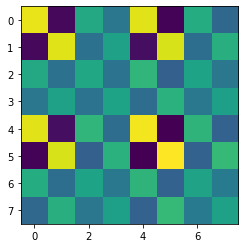

   5.2124  -5.05124    1.27415  -0.960835   5.06136  -5.16478    1.42982    -1.6371  
 -5.05124   5.05214   -1.18732   0.933569  -4.89342   4.89916    -1.3636    1.54113  
  1.27415  -1.18732    1.24166   -1.12661   1.84012  -1.93831    1.00032  -0.985141  
-0.960835  0.933569   -1.12661    1.02643  -1.41958   1.64692  -0.927667   0.858968  
  5.06136  -4.89342    1.84012   -1.41958   5.38978  -5.27635    1.79447   -1.87986  
 -5.16478   4.89916   -1.93831    1.64692  -5.27635   5.56422    -1.8548    2.00262  
  1.42982   -1.3636    1.00032  -0.927667   1.79447   -1.8548    0.95609  -0.848978  
  -1.6371   1.54113  -0.985141   0.858968  -1.87986   2.00262  -0.848978   0.908317  
e3 - e4 : 
 0  
 0  
 0  
 0  
 0  
 0  
 1  
-1  
MM True = 
[[ 1.         -1.          0.37454012 -0.37454012  0.95071431 -0.95071431
   0.73199394 -0.73199394]
 [-1.          1.         -0.37454012  0.37454012 -0.95071431  0.95071431
  -0.73199394  0.73199394]
 [ 0.37454012 -0.37454012  1.         -1.       

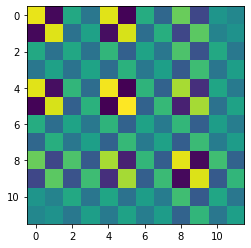

   5.2124  -5.05124    1.27415  -0.960835    5.06136  -5.16478    1.42982    -1.6371   3.06802  -2.95856   0.388661  -0.267664  
 -5.05124   5.05214   -1.18732   0.933569   -4.89342   4.89916    -1.3636    1.54113  -2.98671   2.81747    -0.4453   0.261891  
  1.27415  -1.18732    1.24166   -1.12661    1.84012  -1.93831    1.00032  -0.985141   2.54045  -2.52091    1.25554  -0.945955  
-0.960835  0.933569   -1.12661    1.02643   -1.41958   1.64692  -0.927667   0.858968  -2.16624   2.18838   -1.01452   0.812153  
  5.06136  -4.89342    1.84012   -1.41958    5.38978  -5.27635    1.79447   -1.87986   4.12628  -3.81867    1.08411  -0.836578  
 -5.16478   4.89916   -1.93831    1.64692   -5.27635   5.56422    -1.8548    2.00262  -4.29552   4.08552   -1.17177   0.951692  
  1.42982   -1.3636    1.00032  -0.927667    1.79447   -1.8548    0.95609  -0.848978   1.91798    -1.992   0.755513  -0.670638  
  -1.6371   1.54113  -0.985141   0.858968   -1.87986   2.00262  -0.848978   0.908317  -2.04402   

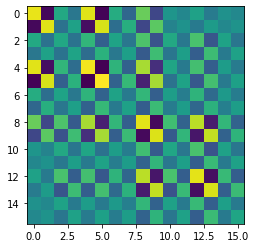

   5.2124   -5.05124    1.27415  -0.960835    5.06136   -5.16478    1.42982    -1.6371   3.06802  -2.95856   0.388661  -0.267664    0.94077  -0.747624   0.208039   -0.21859  
 -5.05124    5.05214   -1.18732   0.933569   -4.89342    4.89916    -1.3636    1.54113  -2.98671   2.81747    -0.4453   0.261891  -0.870086   0.676005  -0.219276   0.280071  
  1.27415   -1.18732    1.24166   -1.12661    1.84012   -1.93831    1.00032  -0.985141   2.54045  -2.52091    1.25554  -0.945955    2.44271   -2.36903   0.986512   -1.02479  
-0.960835   0.933569   -1.12661    1.02643   -1.41958    1.64692  -0.927667   0.858968  -2.16624   2.18838   -1.01452   0.812153   -2.05029    2.14906  -0.829679   0.946292  
  5.06136   -4.89342    1.84012   -1.41958    5.38978   -5.27635    1.79447   -1.87986   4.12628  -3.81867    1.08411  -0.836578    2.31688   -2.04636    0.70462  -0.752267  
 -5.16478    4.89916   -1.93831    1.64692   -5.27635    5.56422    -1.8548    2.00262  -4.29552   4.08552   -1.17177   0.951

arg q-func : 
[[0.97506491]]
[0.19199999999999995, 0.183, 0.179, 0.18] [0.1846551955881806, 0.16569290047501584, 0.16489688061627777, 0.16171012219375985]
10
[[1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200]]
12000
0.3745401188473625
0.9507143064099162
0.7319939418114051
0.5986584841970366
0.15601864044243652
0.15599452033620265
0.05808361216819946
0.8661761457749352
0.6011150117432088
0 0
500
1 1
500
2 2
100
3 3
100
4 4
500
5 5
500
6 6
100
7 7
100
8 8
500
9 9
500
10 10
100
11 11
100
12 12
500
13 13
500
14 14
100
15 15
100
16 16
500
17 17
500
18 18
100
19 19
100
MM : 
 [[ 1.04247939 -1.01024803  0.56981732 -0.42969837  1.01227283 -1.03295518
   0.63943539 -0.73213126  0.61360431 -0.59171199  0.17381444 -0.11970306
   0.18815401 -0.14952476  0.09303801 -0.09775648  0.89030302 -0.89147707
   0.52126593 -0.5959099 ]
 [-1.01024803  1.01042755 -0.53098643  0.41750456 -0.97868492  0.97983153
  -0.60982101  0.6892

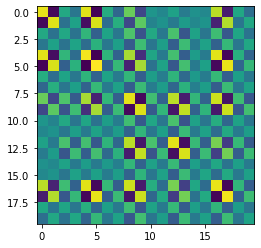

   5.2124   -5.05124    1.27415  -0.960835    5.06136   -5.16478    1.42982    -1.6371   3.06802  -2.95856   0.388661  -0.267664    0.94077  -0.747624   0.208039   -0.21859   4.45152  -4.45739    1.16559    -1.3325  
 -5.05124    5.05214   -1.18732   0.933569   -4.89342    4.89916    -1.3636    1.54113  -2.98671   2.81747    -0.4453   0.261891  -0.870086   0.676005  -0.219276   0.280071  -4.24311   4.31908   -1.03894    1.22067  
  1.27415   -1.18732    1.24166   -1.12661    1.84012   -1.93831    1.00032  -0.985141   2.54045  -2.52091    1.25554  -0.945955    2.44271   -2.36903   0.986512   -1.02479   2.20404   -2.3024    1.08408   -1.13822  
-0.960835   0.933569   -1.12661    1.02643   -1.41958    1.64692  -0.927667   0.858968  -2.16624   2.18838   -1.01452   0.812153   -2.05029    2.14906  -0.829679   0.946292  -1.87006   1.94091  -0.972334    1.18106  
  5.06136   -4.89342    1.84012   -1.41958    5.38978   -5.27635    1.79447   -1.87986   4.12628  -3.81867    1.08411  -0.836578    

 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 1  
-1  
y = 
  9.9076  
 4.50018  
-10.0013  
-30.5621  
  2.4272  
-3.94392  
 7.55028  
 6.98899  
 7.92296  
-15.9502  
-12.5127  
 7.79304  
 3.02797  
-14.3988  
 3.90251  
-18.7426  
-9.13557  
-2.22441  
-80.0861  
 30.7655  
y true = 
 0.649634  
-0.649634  
  3.05984  
 -3.05984  
  1.55949  
 -1.55949  
   2.5451  
  -2.5451  
  2.82206  
 -2.82206  
  3.10179  
 -3.10179  
  3.10178  
 -3.10178  
  3.07023  
 -3.07023  
  2.08072  
 -2.08072  
  2.81806  
 -2.81806  
arg q-func : 
[[0.98825807]]
[0.19199999999999995, 0.183, 0.179, 0.18, 0.19599999999999995] [0.1846551955881806, 0.16569290047501584, 0.16489688061627777, 0.16171012219375985, 0.16008424548293226]
12
[[1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200], [1000, 1000], [200, 200]]
14400
0.3745401188473625
0.9507143064099162
0.7319939418114051
0.5986584841970366
0.15601864044243

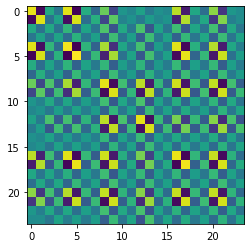

    5.2124   -5.05124    1.27415  -0.960835    5.06136   -5.16478    1.42982    -1.6371   3.06802  -2.95856   0.388661  -0.267664    0.94077  -0.747624   0.208039   -0.21859   4.45152  -4.45739    1.16559    -1.3325   3.66591  -3.57994   0.456739  0.00963828  
  -5.05124    5.05214   -1.18732   0.933569   -4.89342    4.89916    -1.3636    1.54113  -2.98671   2.81747    -0.4453   0.261891  -0.870086   0.676005  -0.219276   0.280071  -4.24311   4.31908   -1.03894    1.22067  -3.53499   3.50746  -0.578381    0.058871  
   1.27415   -1.18732    1.24166   -1.12661    1.84012   -1.93831    1.00032  -0.985141   2.54045  -2.52091    1.25554  -0.945955    2.44271   -2.36903   0.986512   -1.02479   2.20404   -2.3024    1.08408   -1.13822   2.28816  -2.49031    1.22136   -0.971867  
 -0.960835   0.933569   -1.12661    1.02643   -1.41958    1.64692  -0.927667   0.858968  -2.16624   2.18838   -1.01452   0.812153   -2.05029    2.14906  -0.829679   0.946292  -1.87006   1.94091  -0.972334    1.18106  

-0.0460283   0.0460283  -0.934724   0.934724  -0.736947   0.736947  -0.696235   0.696235  -1.81828   1.81828  -0.990756   0.990756   -2.21541    2.21541  -0.999296   0.999296  -1.15708   1.15708  -0.811367   0.811367  -1.61123   1.61123          -1           1  
c0 :  0.006944444444444444
e3 - e4 : 
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 0  
 1  
-1  
y = 
 -12.7914  
 -1.92948  
 -28.1143  
 -17.3853  
 -8.93561  
  1.55705  
  14.5554  
 -1.97879  
  11.5293  
  2.01889  
  2.56477  
-0.644626  
  16.3535  
 -11.6105  
   8.0382  
  -14.661  
  6.68854  
 -5.49118  
 -20.6049  
  27.6956  
  10.1514  
 -3.26964  
 -17.1392  
  43.9287  
y true = 
  -3.52655  
   3.52655  
   4.52556  
  -4.52556  
  -1.39765  
   1.39765  
    1.7145  
   -1.7145  
   2.93942  
  -2.93942  
   5.67794  
  -5.67794  
   5.67805  
  -5.67805  
   6.08988  
  -6.08988  
 0.0964185  
-0.0964185  
   2.91914  
  -2.91914  
   1.95541  
  -

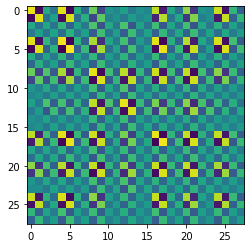

    5.2124   -5.05124    1.27415  -0.960835    5.06136   -5.16478    1.42982    -1.6371   3.06802  -2.95856   0.388661  -0.267664    0.94077  -0.747624   0.208039   -0.21859   4.45152  -4.45739    1.16559    -1.3325   3.66591  -3.57994   0.456739  0.00963828    4.69899   -4.73113    1.85977   -1.86706  
  -5.05124    5.05214   -1.18732   0.933569   -4.89342    4.89916    -1.3636    1.54113  -2.98671   2.81747    -0.4453   0.261891  -0.870086   0.676005  -0.219276   0.280071  -4.24311   4.31908   -1.03894    1.22067  -3.53499   3.50746  -0.578381    0.058871   -4.54747    4.58301   -1.84699    1.91086  
   1.27415   -1.18732    1.24166   -1.12661    1.84012   -1.93831    1.00032  -0.985141   2.54045  -2.52091    1.25554  -0.945955    2.44271   -2.36903   0.986512   -1.02479   2.20404   -2.3024    1.08408   -1.13822   2.28816  -2.49031    1.22136   -0.971867    1.64323   -1.58857    0.96363  -0.928451  
 -0.960835   0.933569   -1.12661    1.02643   -1.41958    1.64692  -0.927667   0.8589

  -4.75357     4.75357   -1.43909    1.43909         -5          5   -2.02849    2.02849   -4.0876    4.0876   -1.01652    1.01652   -2.27289    2.27289  -0.815641   0.815641   -4.8922    4.8922   -1.83197    1.83197  -4.46063   4.46063   -0.736947    0.736947   -4.98799    4.98799   -2.15384    2.15384  
   1.63679    -1.63679    0.90588   -0.90588    2.02849   -2.02849          1         -1   2.20017  -2.20017   0.787173  -0.787173    1.76014   -1.76014   0.722678  -0.722678   2.17908  -2.17908   0.984491  -0.984491   2.23474  -2.23474    0.696235   -0.696235    1.95844   -1.95844   0.986865  -0.986865  
  -1.63679     1.63679   -0.90588    0.90588   -2.02849    2.02849         -1          1  -2.20017   2.20017  -0.787173   0.787173   -1.76014    1.76014  -0.722678   0.722678  -2.17908   2.17908  -0.984491   0.984491  -2.23474   2.23474   -0.696235    0.696235   -1.95844    1.95844  -0.986865   0.986865  
   2.99329    -2.99329     2.1621    -2.1621     4.0876    -4.0876    2.20017  

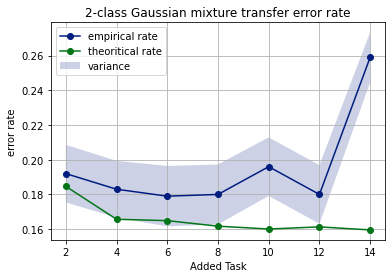

In [33]:
# %%prun -s cumulative
# profiling
p = 100
m = 2
# on ajoute des tâches 2 par 2
t = range(2,16, 2)
multiple = 20
to_add = [50*multiple, 50*multiple], [10*multiple, 10*multiple]
n_t = []
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
random_state = 42

for b in t:
    n_t.append(to_add[0])
    n_t.append(to_add[1])
    
    print(b)
    print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(b)))))
    print(n)
    # on crée les données synthétiques
    M = mean_matrix(p, beta=None, k=b, random_seed=random_state, random=True)
       
    X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M, random_state)
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(b, m, X, p, n_t)
    print("MM : \n", MM)
    temps_MM.append(time() - t0)
    # On time le calcul de MTM

    t0 = time()
    c = estimate_c(n_t, n, b, m)
    print("c : ")
    print(c)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=True)
    matprint(correlation_matrix)
    y = label_evaluation(b,m,Dc,MM, c0)
    temps_estim.append(time() - t0)
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    print("MM True = ")
    print(MM_true)
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    matprint(correlation_matrix_true)
    print("c0 : ", c0)
    y_true = label_evaluation(b,m,Dc,MM_true, c0)
    print("y = ")
    matprint(y)
    print("y true = ")
    matprint(y_true)
    X = normalisation(X, p)
    X_test = normalisation(X_test, p)
    X_train_aggregated = aggregate_array(X, p, n, b, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    J = create_J(m, b, n, n_t)
    
    t0 = time()
    V = compute_V(y, X_train_aggregated, J, n)
    temps_inference.append(time() - t0)
    # On time le temps d'inférence
    
    V_true = compute_V(y_true, X_train_aggregated, J, n)
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
    # pour l'instant pas vraiment utilisé
    m_t = create_mt(b, m, y, Dc, correlation_matrix)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true)
    
    erreur_empirique = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0)
    erreur_theorique = error_rate(b, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    print(emp_rate, th_rate)
    
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(t, emp_rate, '-o', label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (13,) and (0,)

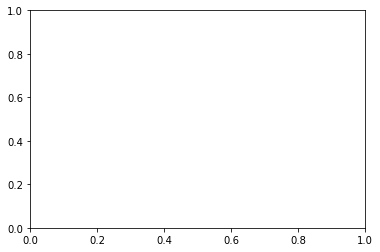

In [27]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(range(13), emp_rate, '-o', label='empirical rate')
plt.plot(range(13), th_rate, '-o', label='theoritical rate')
plt.fill_between(range(13), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Algorithme distribué k tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### k serveurs 
#### Federated Learning 2 classes k taches
Imaginons 1 Serveur central et k clients. L'un cherche à classifier un certain type d'images, l'autre un deuxième type d'images. Les deux clients sont confrontés un problème de classification binaire sur des images sensiblement similaire (quantifié par le paramètre $\beta$), et peuvent donc s'aider du training de l'autre pour affiner leur classification.

Le premier client entraîne son modèle de classification sur son jeu de données locales. Il espère obtenir de meilleures performances à l'aide du transfer Learning. Les deux clients envoient alors les moyennes empiriques calculées sur leurs donnée locales, au serveur central. Le serveur peut alors calculé la matrice de corrélation $\mathcal{M}$ et les labels optimaux $\tilde{y}$. Les clients recoivent les labels optimaux, et peuvent maintenant recalculer le vecteur propre $V$ de $\displaystyle\frac{X_ty_ty_t^TX_t^T}{np}$ et inférer sur de nouvelles données $x$.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [25]:
def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data 
    retourne la matrice M de taille px4
    """
    M = np.empty((nb_classes*nb_tasks, p))
    diag = []
    for t in range(nb_tasks):
        for l in range(nb_classes):
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            M[t*nb_classes+l] /= n_t[t][l]
            
            moitie = int(n_t[t][l]/2)
#             print("shape X : ", X[t][l].T[:moitie].T.shape)
            mu1 = 1/moitie*X[t][l].T[:moitie].T@np.ones((moitie))
            mu2 = 1/moitie*X[t][l].T[moitie:].T@np.ones((moitie))
            mu1, mu2 = np.reshape(mu1, (p, 1)), np.reshape(mu2, (p, 1))
#             print(mu1.shape)
#             print(mu2.shape)
            diag.append(mu1.T@mu2)
    
    return M.T, diag

# diag1 = [mu1]
#diag_means = [[mu1], [mu2]]

def gather_empirical_mean(nb_tasks, nb_classes, emp_means, diag_means, p, n_t):
    """
    emp_means est un vecteur contenant les moyennes empiriques de chaque tache de chaque classe.
    Chaque vecteur de moyennes et de taille px1
    Renvoie la matrice M des, produits scalaires entre moyennes empiriques de chaque client
    """
    M = np.empty((2*nb_tasks, 2*nb_tasks)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(len(emp_means[i*nb_classes+j])/2)
                        #print(f"i = {i}, j = {j}")
#                         print(i*nb_tasks+j, i*nb_tasks+j)
#                         print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
#                         print(emp_means[i*nb_tasks+j][:moitie].T.shape)
                        M[i*nb_classes+j][i*nb_classes+j] = diag_means[i*nb_classes+j]
                    else:
#                         print(i*nb_tasks+j, k*nb_tasks+l)
#                         print(emp_means[i*nb_tasks+j].T.shape)
#                         print(emp_means[k*nb_tasks+l].shape)
                        M[i*nb_classes+j][k*nb_classes+l] = emp_means[i*nb_classes+j].T.dot(emp_means[k*nb_classes+l])
#                         print(M[i*nb_tasks+j][k*nb_tasks+l].shape)
                
    return M

In [26]:
def merging_center(MM, diag, t, m, p, n_t):
    """
    Recoit les moyennes empiriques des k clients, calcule la matrice de corrélation, les labels optimaux et renvoie le vecteur V
    """
    # MM = [[MM11, MM12], [MM21, MM22], [MM31, MM32], ...]
    emp_means = []
    diagonal = []
    for i in range(len(MM)):
        emp_means.append(np.reshape(MM[i].T[0], (p, 1)))
        emp_means.append(np.reshape(MM[i].T[1], (p, 1)))
        diagonal.append(diag[i][0])
        diagonal.append(diag[i][1])
    #diag = [diag1[0], diag1[1], etc.]
    #emp_means = [MM11, MM12, MM21, MM22, MM31, ...]
    MM_gathered = gather_empirical_mean(t, m, emp_means, diagonal, p, n_t)
#     print("MM_gathered : ")
#     matprint(MM_gathered)
    
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
#     print("c = ", c)
#     print("Correlation Matrix : ")
    correlation_matrix = compute_M_cal(n, p, Dc, MM_gathered, display=True)
    
    # faire une label evaluation en fonction de la target
    y = label_evaluation(t,m,Dc,MM_gathered, c0)
    
    # le serveur calcule aussi
    V = np.empty((p,1))
    for i in range(t):
        for j in range(m):
            V += n_t[i][j]*emp_means[i*m+j]*y[i*m+j]
    V /= np.linalg.norm(V)
    V = np.reshape(V, (p))
    
    return V, y, correlation_matrix, Dc, c0

(100, 1000)


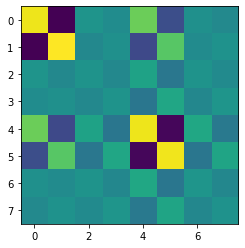

   4.75962    -4.8477   0.239266  -0.0487519    2.80436   -2.46469   0.087654  -0.202113  
   -4.8477    5.00614  -0.245751   0.0801754   -2.65721    2.44804  -0.104754   0.189924  
  0.239266  -0.245751   0.206062   -0.256947   0.841165  -0.940548   0.200932  -0.122593  
-0.0487519  0.0801754  -0.256947    0.210635   -0.98378   0.978648  -0.276638   0.274716  
   2.80436   -2.65721   0.841165    -0.98378     4.7648   -4.68077    1.00486  -0.878508  
  -2.46469    2.44804  -0.940548    0.978648   -4.68077    4.79275  -0.972465   0.925074  
  0.087654  -0.104754   0.200932   -0.276638    1.00486  -0.972465   0.293824   -0.26874  
 -0.202113   0.189924  -0.122593    0.274716  -0.878508   0.925074   -0.26874   0.160076  
-1.14316  
0.263579  
 -5.1812  
-8.42514  
 2.05041  
-1.73518  
 7.58415  
-0.47826  
(100, 1000)


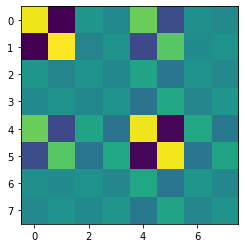

  4.75962    -4.8477   0.360285  -0.169771    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.369638   0.204062   -2.65721    2.44804  -0.104754   0.189924  
 0.360285  -0.369638   0.219814  -0.265609   0.904321  -0.997508   0.202924  -0.126601  
-0.169771   0.204062  -0.265609   0.214207   -1.04694    1.03561   -0.27863   0.278723  
  2.80436   -2.65721   0.904321   -1.04694     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804  -0.997508    1.03561   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.202924   -0.27863    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.126601   0.278723  -0.878508   0.925074   -0.26874   0.160076  
 -1.15178  
  0.27228  
 -5.17504  
 -8.43763  
  2.05046  
 -1.73462  
  7.58193  
-0.479274  
(100, 1000)


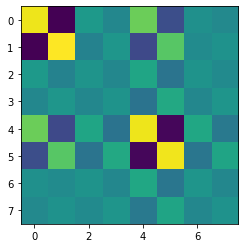

  4.75962    -4.8477    0.48119  -0.290676    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.493995    0.32842   -2.65721    2.44804  -0.104754   0.189924  
  0.48119  -0.493995   0.234537  -0.274623    0.95618   -1.04275   0.201952  -0.127981  
-0.290676    0.32842  -0.274623   0.217513   -1.09879    1.08085  -0.277658   0.280104  
  2.80436   -2.65721    0.95618   -1.09879     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804   -1.04275    1.08085   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.201952  -0.277658    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.127981   0.280104  -0.878508   0.925074   -0.26874   0.160076  
 -1.16117  
 0.281694  
 -5.17403  
 -8.44416  
  2.05195  
 -1.73545  
  7.57989  
-0.481139  
(100, 1000)


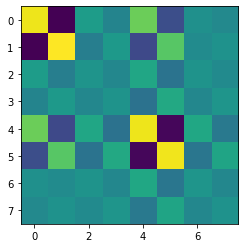

  4.75962    -4.8477   0.601973  -0.411459    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.618852   0.453277   -2.65721    2.44804  -0.104754   0.189924  
 0.601973  -0.618852    0.25029   -0.28401   0.996066   -1.07558   0.197838  -0.126577  
-0.411459   0.453277   -0.28401   0.220535   -1.13868    1.11368  -0.273544     0.2787  
  2.80436   -2.65721   0.996066   -1.13868     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804   -1.07558    1.11368   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.197838  -0.273544    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.126577     0.2787  -0.878508   0.925074   -0.26874   0.160076  
-1.17129  
0.291761  
-5.17878  
-8.44394  
 2.05499  
-1.73779  
 7.57809  
 -0.4839  
(100, 1000)


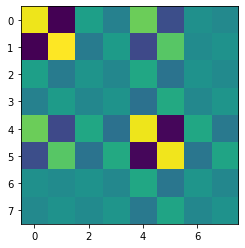

  4.75962    -4.8477   0.722621  -0.532107    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.744262   0.578687   -2.65721    2.44804  -0.104754   0.189924  
 0.722621  -0.744262   0.267183  -0.293811    1.02269   -1.09465   0.190243  -0.122089  
-0.532107   0.578687  -0.293811   0.223243    -1.1653    1.13275  -0.265949   0.274212  
  2.80436   -2.65721    1.02269    -1.1653     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804   -1.09465    1.13275   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.190243  -0.265949    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.122089   0.274212  -0.878508   0.925074   -0.26874   0.160076  
  -1.1821  
 0.302408  
  -5.1903  
 -8.43571  
  2.05971  
 -1.74179  
   7.5766  
-0.487626  
(100, 1000)


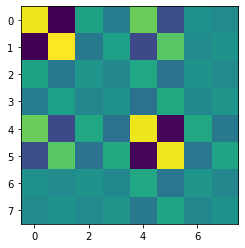

  4.75962    -4.8477   0.843111  -0.652597    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.870319   0.704743   -2.65721    2.44804  -0.104754   0.189924  
 0.843111  -0.870319   0.285409  -0.304095    1.03381   -1.09764   0.178579  -0.113995  
-0.652597   0.704743  -0.304095   0.225585   -1.17642    1.13574  -0.254285   0.266118  
  2.80436   -2.65721    1.03381   -1.17642     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804   -1.09764    1.13574   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.178579  -0.254285    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.113995   0.266118  -0.878508   0.925074   -0.26874   0.160076  
 -1.19356  
 0.313551  
 -5.21018  
  -8.4175  
  2.06633  
 -1.74767  
  7.57553  
-0.492428  
(100, 1000)


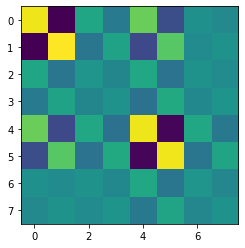

  4.75962    -4.8477   0.963402  -0.772889    2.80436   -2.46469   0.087654  -0.202113  
  -4.8477    5.00614  -0.997188   0.831613   -2.65721    2.44804  -0.104754   0.189924  
 0.963402  -0.997188   0.305314  -0.314988    1.02541    -1.0804   0.161795  -0.101364  
-0.772889   0.831613  -0.314988   0.227466   -1.16802     1.1185  -0.237501   0.253486  
  2.80436   -2.65721    1.02541   -1.16802     4.7648   -4.68077    1.00486  -0.878508  
 -2.46469    2.44804    -1.0804     1.1185   -4.68077    4.79275  -0.972465   0.925074  
 0.087654  -0.104754   0.161795  -0.237501    1.00486  -0.972465   0.293824   -0.26874  
-0.202113   0.189924  -0.101364   0.253486  -0.878508   0.925074   -0.26874   0.160076  
 -1.20562  
 0.325071  
 -5.24108  
 -8.38602  
  2.07518  
  -1.7558  
  7.57508  
-0.498489  
(100, 1000)


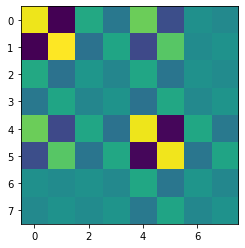

  4.75962    -4.8477     1.08341  -0.892901    2.80436   -2.46469   0.087654   -0.202113  
  -4.8477    5.00614     -1.1252   0.959628   -2.65721    2.44804  -0.104754    0.189924  
  1.08341    -1.1252    0.327581  -0.326737   0.989538   -1.03466     0.1378  -0.0823433  
-0.892901   0.959628   -0.326737   0.228697   -1.13215    1.07276  -0.213506    0.234466  
  2.80436   -2.65721    0.989538   -1.13215     4.7648   -4.68077    1.00486   -0.878508  
 -2.46469    2.44804    -1.03466    1.07276   -4.68077    4.79275  -0.972465    0.925074  
 0.087654  -0.104754      0.1378  -0.213506    1.00486  -0.972465   0.293824    -0.26874  
-0.202113   0.189924  -0.0823433   0.234466  -0.878508   0.925074   -0.26874    0.160076  
 -1.21828  
 0.336787  
 -5.28802  
 -8.33513  
  2.08692  
 -1.76685  
  7.57557  
-0.506145  
(100, 1000)


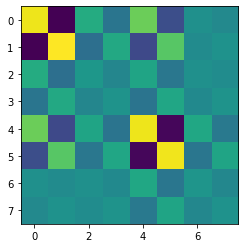

  4.75962    -4.8477     1.20294   -1.01243    2.80436   -2.46469   0.087654   -0.202113  
  -4.8477    5.00614    -1.25522    1.08964   -2.65721    2.44804  -0.104754    0.189924  
  1.20294   -1.25522    0.353973  -0.339981   0.905686  -0.939165   0.101215  -0.0521652  
 -1.01243    1.08964   -0.339981   0.228793    -1.0483   0.977265  -0.176921    0.204288  
  2.80436   -2.65721    0.905686    -1.0483     4.7648   -4.68077    1.00486   -0.878508  
 -2.46469    2.44804   -0.939165   0.977265   -4.68077    4.79275  -0.972465    0.925074  
 0.087654  -0.104754    0.101215  -0.176921    1.00486  -0.972465   0.293824    -0.26874  
-0.202113   0.189924  -0.0521652   0.204288  -0.878508   0.925074   -0.26874    0.160076  
-1.23158  
0.348353  
-5.36339  
-8.24967  
 2.10306  
-1.78245  
 7.57784  
-0.51623  
(100, 1000)


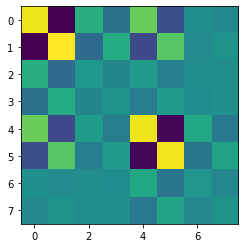

  4.75962    -4.8477      1.31984    -1.12933    2.80436   -2.46469     0.087654  -0.202113  
  -4.8477    5.00614     -1.39597      1.2304   -2.65721    2.44804    -0.104754   0.189924  
  1.31984   -1.39597     0.402512   -0.361254   0.564289  -0.576577  -0.00295485  0.0379027  
 -1.12933     1.2304    -0.361254      0.2228  -0.706903   0.614677   -0.0727511    0.11422  
  2.80436   -2.65721     0.564289   -0.706903     4.7648   -4.68077      1.00486  -0.878508  
 -2.46469    2.44804    -0.576577    0.614677   -4.68077    4.79275    -0.972465   0.925074  
 0.087654  -0.104754  -0.00295485  -0.0727511    1.00486  -0.972465     0.293824   -0.26874  
-0.202113   0.189924    0.0379027     0.11422  -0.878508   0.925074     -0.26874   0.160076  
 -1.24758  
 0.357875  
 -5.58879  
   -7.982  
  2.13853  
 -1.81829  
  7.58956  
-0.537029  


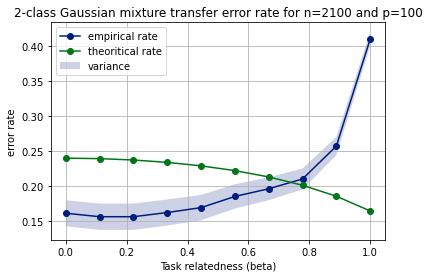

In [68]:
n1 = 2000
n2 = 100
n = n1+n2
p = 100
m = 2
t = 4
ni = [n1, n2, n1, n2]
beta = np.linspace(0,1,10)
n_t = [[int(n1/2),int(n1/2)], [int(n2/2), int(n2/2)], [int(n1/2),int(n1/2)], [int(n2/2), int(n2/2)]]
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
emp_rate, th_rate, var = [], [], []

t_MM1 = []
t_MM2 = []
t_SC = []
t_inf1 = []
t_inf2 = []

random_state = 100

for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
#       print(M)
    # X1 is the local data of the first client
    # normalisation?
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    # ici on prend exactement les memes données que dans l'algo du dessus.
    
    X1 = [X[0]]
    # X2 is the local data of the second client
    X2 = [X[1]]
    print(X1[0][0].shape)
    
    # data we want to test on our model, here new data of client n°2
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)
    
    MM = []
    diag = []
    
    # On calcule les moyennes empiriques sur les données locales
    # diag1 = [diag1[0], diag1[1]]
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        MM.append(MM1)
        diag.append(diag1)
    X = normalisation(X, p)

# CENTRAL SERVER
    # sending empirical means to central server
    V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n_t)
    matprint(correlation_matrix)
    matprint(y)
    
    # when to normalize the data ?
    X_test = normalisation(X_test, p)

# END CENTRAL SERVER

    # Sending back optimal labels to clients
    aggregated = []
    for i in range(t):
        aggregated.append(aggregate_array([X[i]], p, ni[i], 1, m))
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    # ou alors créer un J ?
#     J = create_J(m, 2, n, n_t)
    
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     print("V = ")
#     print(V)
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
#     th_rate.append(error_rate(t, m,  Dc, MM_true, c0)[0][0])
#     print(emp_rate, th_rate)
    
# pour pas le recalculer a chaque fois 
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

# print(f"temps moyen client 1 : {round(np.mean(t_MM1), 5)}, {round(np.mean(t_inf1), 5)}")
# print(f"temps moyen client 2 : {round(np.mean(t_MM2), 5)}, {round(np.mean(t_inf2), 5)}")
# print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)}")
# print(f"temps total moyen : {round(max(np.mean(t_MM1), np.mean(t_MM2)) + max(np.mean(t_inf1), np.mean(t_inf2)) + np.mean(t_SC), 5)}")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [ ]:
4.75962   -4.8477    1.08341  -0.892901  
  -4.8477   5.00614    -1.1252   0.959628  
  1.08341   -1.1252   0.327581  -0.326737  
-0.892901  0.959628  -0.326737   0.228697 

In [46]:
print(i)

2


temps moyen client 1 : 0.00281, 0.0 s
temps moyen client 2 : 0.00036, 0.0 s
temps moyen Serveur central : 0.00204 s
temps total moyen (sans coût de transport) : 0.00485 s


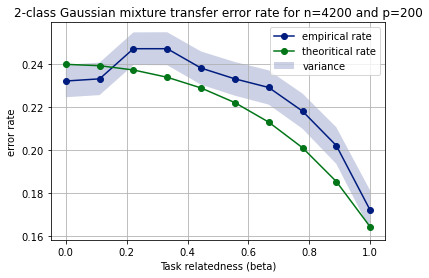

In [41]:
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

print(f"temps moyen client 1 : {round(np.mean(t_MM1), 5)}, {round(np.mean(t_inf1), 5)} s")
print(f"temps moyen client 2 : {round(np.mean(t_MM2), 5)}, {round(np.mean(t_inf2), 5)} s")
print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)} s")
print(f"temps total moyen (sans coût de transport) : {round(max(np.mean(t_MM1), np.mean(t_MM2)) + max(np.mean(t_inf1), np.mean(t_inf2)) + np.mean(t_SC), 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Algorithme distribué k-tâches m classes
On se ramène à un cas 2-tâches 2-classes en fait

In [28]:
from sklearn.preprocessing import normalize

def z_normalize(X, k, m):
    """
    Normalise les données.
    k tâches, m classes
    X le tableau de données.
    """
    for t in range(k):
        for l in range(m):
            X[t][l] = normalize(X[t][l], axis=1)
    return X

In [174]:
# Algorithme 1 du papier
k = 2
m = 10
n1 = [100 for i in range(m)]
n2 = [50 for i in range(m)]
p = 100
n_t = [n1, n2]
n_t_test = [[1000 for i in range(m)]]
nt = sum(n_t_test[0])
# faire quelque chose de généralisable
n = sum(list(map(sum, (n_t[i] for i in range(k)))))
c0 = p/n
var = []
emp_rate = []
scores = []
random_state=100
# si je peux essayer de faire plus dégeu pour le n 
M = mean_matrix(p, k=k, m=m, random_seed=random_state, random=True)
X, y_bs = gaussian_synthetic_data(n, p, m, k, n_t, M, random_state)

# choisir la tache que l'on veut tester
test_task = 1
X_test, y_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[test_task]], random_state)
X, X_test = z_normalize(X, k, m), z_normalize(X_test, 1, m)
# beta = []
# [[[],[]], [[], []]]

# inverser les boucles ?
for l in range(m):
    for t in range(k):
        if t==test_task:
            # how does it benefit from the other tasks?
            # pourquoi faire une boucle sur les tâches ?
    #         beta.append(l*k+t)
            X_data = []
            # on ajoute la premiere classe de la premiere tache
            X_data.append([X[t][l]])
            current_n_t = [[n_t[t][l]]]
            s = 0           

            tmp = np.empty((p, 0), float)
    #         print("tmp : ", tmp)
            for cl in range(m):
                if cl==l:
                    continue
    #             print("on ajoute : ", X[t][cl])
    #             print(X[t][cl].shape)
                tmp = np.concatenate((tmp, X[t][cl]), axis=1)
                s += n_t[t][cl]
    #         print("tmp : ", tmp)
            X_data[0].append(tmp)
    #         qui est la deuxieme tâche ? 
    #         X_data.append(X_test[0])
#             regrouper toutes les autres tâches
#             a reprendre
            temp = []
            tmp1 = np.empty((p, 0), float)
            s1 = 0
            sc = []
            for tp in range(k):
                if tp == test_task:
                    continue
                for l in range(m):
                    tmp1 = np.concatenate((tmp1, X[tp][l]), axis=1)
                    s1 += n_t[tp][l]
                temp.append(tmp1)
                sc.append(s2)
                sc.append(s1)
            X_data.append(temp)
    #         print("len(X) : ", len(X_data))
    #         print("len(X[0]) : ", len(X_data[1][0]))
            current_n_t[0].append(s)
            current_n_t.append(sc)
            print(f"current nt = {current_n_t}")
            MM = empirical_mean(2, 2, X_data, p, current_n_t)
            matprint(MM)
            c = estimate_c(current_n_t, n, 2, 2)
            Dc = np.diag(c)
            matprint(Dc)
            correlation_matrix = compute_M_cal(n, p, Dc, MM, 2, True)

            y = label_evaluation(2, 2, Dc, MM, c0)
            matprint(y)
            X_aggregated = aggregate_array(X_data, p, n, 2, 2)
            X_test_aggregated = aggregate_array(X_test, p, nt, 1, 2)

            # no need to compute V anymore
            J = create_J(2, 2, n, current_n_t)
            V = compute_V(y, X_aggregated, J, n)
            # On time le temps d'inférence

        #     debug_histogram(V_true, X_test_aggregated, n_t_test)
        #     print("V = ")
            VTX = V.T@X_test_aggregated
            var.append(np.var(VTX))
            debug_histogram(V, X_test_aggregated, n_t_test)

            # pour l'instant pas vraiment utilisé
            m_t = create_mt(2, 2, y, Dc, correlation_matrix)
            # gxt in R^1xn

            gxt = y.T@J.T@X_aggregated.T@X_test_aggregated/np.linalg.norm(y.T@J.T@X_aggregated.T)
            gxt = np.reshape(gxt, (nt))
            scores.append(gxt-m_t[0][0])

            erreur_empirique = compute_error_rate(X_test, V, m_t, 1, 2, n_t_test, Dc, c0)
    #         erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
            emp_rate.append(erreur_empirique)
    #         th_rate.append(erreur_theorique)
    #         relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)

estimated_class=[]
for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))

        
        
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.legend()
# plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
# plt.xlabel("Task relatedness (beta)")
# plt.ylabel("error rate")
# plt.grid()
# plt.show()
        

current nt = [[50, 450], [0, 1000]]
0 0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 1000)

In [162]:
print(X_data[1][1].shape)

(100, 1000)


In [168]:
estimated_class = []
erreur= []

for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))
    erreur.append(int(np.argmax(classes)==y_test[j]))
    
err = erreur.count(1)/len(scores[0])
if err>0.5:
    err = 1-err

print(err)
# estimated_class
# print(np.argmax(scores[l][0] for l in range(m)))
# print(np.argmax((scores[0][0], scores[1][0])))

0.5
800


In [165]:
ones=0
twos=0
for i in range(len(scores[0])):
    maxi = scores[0][i]
    indice = 0
    for idx, score in enumerate(scores):
        if score[i] > maxi:
            maxi = score[i]
            indice = idx
    l = indice%2+1
    if l == 1:
        ones+=1
    else:
        twos+=1
    
#     print(l)
print(f"Empirical proportions : \nC1 proportion : {ones/len(scores[0])*100} %, C2 proportion : {twos/len(scores[0])*100} %")
print(f"Theoritical proportions : \nC1 proportion : {round(sum(n1)/(sum(n1)+sum(n2))*100, 3)} %, C2 proportion : {round(sum(n2)/(sum(n1)+sum(n2))*100, 3)} %")

Empirical proportions : 
C1 proportion : 0.0 %, C2 proportion : 100.0 %
Theoritical proportions : 
C1 proportion : 66.667 %, C2 proportion : 33.333 %


In [98]:
print(current_n_t)
print(gxt.shape)
print(J.T.shape)
print(X_aggregated.T.shape)
print(X_test_aggregated.shape)

[[200, 600]]
(1, 800)
(2, 800)
(800, 100)
(100, 800)


In [102]:
print(tmp.shape)
print(s)
print(len(X_data))
print(np.ones((n_t[0][0], 1)).T.shape)
print((X_data[0][0].T.shape))
print((X_data[0][1].shape))
print(np.ones(n_t[0][1]).shape)
#1x240x50
print(X_data)
print(X[3][1])
print(X[3][0])

(2, 2)
2
2
(1, 4)
(2, 2)
(2, 2)
(4,)
[[array([[-0.88007943, -0.47482649],
       [-0.96586158,  0.2590587 ]]), array([[0.92226127, 0.38656715],
       [0.91331841, 0.40724621]])], [array([[0.36683514, 0.43040179, 0.0591088 , 0.82261317],
       [0.24975802, 0.77567657, 0.21940746, 0.53647661]]), array([[-0.34926064, -0.34675433, -0.05486188, -0.8687742 ],
       [-0.1093427 , -0.39596414, -0.807452  , -0.42341213]])]]
[[-0.88007943 -0.47482649]
 [-0.96586158  0.2590587 ]]
[[0.92226127 0.38656715]
 [0.91331841 0.40724621]]


In [65]:
print(n_t[0][0])
print(X[1][0].shape)
print(X_data[0][0].shape)
print(current_n_t)

50
(200, 10)
(200, 50)
[[50, 50], [500, 500]]


In [104]:
n_t = [[10,10], [4,4], [5,5]]
n = sum(list(map(sum, (n_t[i] for i in range(2)))))
print(list(n_t[i] for i in range(3) if i!=0))
current = [n_t[0], list(n_t[i] for i in range(2) if i!=0)[0]]
current

[[4, 4], [5, 5]]


[[10, 10], [[4, 4]]]